#  Pytorchのnnモジュール

## nn.Linear

In [49]:
from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [2]:
linear = nn.Linear(64, 30)

In [3]:
list(linear.parameters())

[Parameter containing:
 tensor([[-0.1246, -0.0422,  0.0933,  ...,  0.0251, -0.1105,  0.0363],
         [-0.0234,  0.0993, -0.1114,  ..., -0.0957, -0.0682, -0.1096],
         [ 0.1018,  0.1114,  0.0463,  ..., -0.1060,  0.0523,  0.1003],
         ...,
         [ 0.0498, -0.0463, -0.0682,  ...,  0.0095,  0.0991, -0.0704],
         [-0.0985, -0.0841,  0.0467,  ...,  0.0300,  0.0731,  0.0420],
         [ 0.0692, -0.0128,  0.1135,  ...,  0.0558,  0.0845,  0.0487]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0701,  0.0687,  0.0008, -0.1068, -0.0593,  0.0167,  0.1090,  0.0478,
         -0.0077,  0.0226,  0.0130, -0.0681, -0.0388, -0.1002,  0.0215, -0.0342,
          0.0385, -0.0796, -0.0171, -0.0766, -0.0219, -0.0937, -0.0837, -0.0441,
         -0.0791,  0.0026, -0.1126,  0.0918, -0.0777, -0.0813],
        requires_grad=True)]

In [4]:
linear.weight.shape # W = 出力 x 入力 (ex : 30 x 64)

torch.Size([30, 64])

In [5]:
linear.bias.shape # b = 1 x 出力

torch.Size([30])

In [6]:
x = torch.randn((5, 64))
Z = linear(x)

上記のcodeはZ = X @ W.T + bを計算している  
Z = (5,64) @ (出力30, 入力64).T + b(1, 出力30)

In [7]:
Z.shape

torch.Size([5, 30])

## MLP実装

### 1 nn.<class>とF.<function>を組み合わせる

In [26]:
# nnクラスとF.関数を組み合わせて作成する
# MLP(親のクラス(継承する))
class MLP(nn.Module):
    """
    流れ : Linear -> 活性化関数(ReLU) -> Linear(出力層) [-> Loss]
    - pytorchは最後の活性化関数とLossはModelに組み込まない
    インスタンス生成時に受け取るもの : それぞれのレイヤーの次元を指定
    """
    def __init__(self, num_in, num_hidden, num_out):
        # 親のclassの継承
        super().__init__()
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_out) # 出力層の全結合層

    # forwardの処理(順伝播の処理)
    def forward(self, x):
        """
        z1 = self.l1(x)
        a1 = F.relu(z1)
        z2 = self.l2(a1)
        上記の処理をまとめて書く
        ただし、層が少ないときに書く。多いと見にくくなるから上記の書き方
        """ 
        
        x = self.l2(F.relu(self.l1(x)))
        return x

    

In [29]:
model = MLP(64, 30, 10)
x = torch.randn(5, 64)
Z = model(x)
print(Z.shape)

torch.Size([5, 10])


### nn.クラスのみで構成する

In [40]:
# 2. nn.classのみで作成する
class MLP(nn.Module):

    def __init__(self, num_in, num_hidden, num_out):

        super().__init__()
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_out)
        self.relu = nn.ReLU()  # <- 一番と異なる点

    def forward(self, x):
        z1 = self.l1(x)
        a1 = self.relu(z1)
        z2 = self.l2(a1)
        """ 
        1行でまとめて書くと
        x = self.l2(self.relu(self.l1(x)))
        """
        return z2

In [41]:
model = MLP(64,30,10)
x = torch.randn(5, 64)
z = model(x)
print(z.shape)

torch.Size([5, 10])


### 3. nn.Sequentialを使ったとき

In [42]:
# 3. nn.Sequentialを使ったとき
num_in = 64
num_hidden = 30
num_out = 10

model = nn.Sequential(
    nn.Linear(num_in, num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, num_out)
)

In [43]:
Z = model(x)
print(Z.shape)

torch.Size([5, 10])


### MLP学習

In [53]:
# nnクラスとF.関数を組み合わせて作成する
# MLP(親のクラス(継承する))
class MLP(nn.Module):
    
    def __init__(self, num_in, num_hidden, num_out):
        # 親のclassの継承
        super().__init__()
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_out) # 出力層の全結合層

    # forwardの処理(順伝播の処理)
    def forward(self, x):
        x = self.l2(F.relu(self.l1(x)))
        return x

## Refactoring後の学習ループ(OptimizerやDataset, Dataloaderの後にRefactaring)
# ===データの準備===
dataset = datasets.load_digits()
data = dataset['data']
target = dataset['target']
images = dataset['images']
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)
X_mean = X_train.mean()
X_std = X_train.std()

X_train = (X_train - X_mean) / X_std
X_val  = (X_val  - X_mean ) / X_std

X_train = torch.tensor(X_train.reshape(-1, 64), dtype=torch.float32)
X_val = torch.tensor(X_val.reshape(-1, 64), dtype=torch.float32)

# yの値をone-hotしないようにする
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)

batch_size = 30
num_in = 64
num_hidden = 30
num_out = 10
num_batches = np.ceil(len(y_train)/batch_size).astype(int)


learning_rate = 0.01

# モデルの初期化
model = MLP(num_in, num_hidden, num_out)

# ログ
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(100):
    # エポックごとにデータをシャッフルする
    shuffled_indices = np.random.permutation(len(y_train))

    running_loss = 0.0

    for i in range(num_batches):
    
        # mini batchの作成
        start = i * batch_size
        end = start + batch_size
    
        batch_indices = shuffled_indices[start:end]
        y = y_train[batch_indices] # batch_size x 10
    
        X = X_train[batch_indices, :] # batc_size x 64
        # 順伝播と逆伝播の計算
        preds  = model(X)
        loss = F.cross_entropy(preds, y)
        loss.backward()
        running_loss += loss.item()
    
        # パラメータ更新
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad
    
        model.zero_grad()

    # validtion
    with torch.no_grad():
        preds_val = model(X_val)
        val_loss = F.cross_entropy(preds_val, y_val)
    
        val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]

    train_losses.append(running_loss/num_batches)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)
    print(f'epoch : {epoch}: train error : {running_loss/num_batches}, validation error : {val_loss.item()},val accuracy {val_accuracy.item()}')



epoch : 0: train error : 2.2702950835227966, validation error : 2.1820578575134277,val accuracy 0.2888889014720917
epoch : 1: train error : 2.1218291521072388, validation error : 2.0305893421173096,val accuracy 0.5527777671813965
epoch : 2: train error : 1.949652411043644, validation error : 1.8470004796981812,val accuracy 0.6666666865348816
epoch : 3: train error : 1.7514753664533298, validation error : 1.6457812786102295,val accuracy 0.7222222089767456
epoch : 4: train error : 1.544384777545929, validation error : 1.443841576576233,val accuracy 0.7861111164093018
epoch : 5: train error : 1.3444657747944195, validation error : 1.2535675764083862,val accuracy 0.8166666626930237
epoch : 6: train error : 1.1649455055594444, validation error : 1.0852824449539185,val accuracy 0.8472222089767456
epoch : 7: train error : 1.01184173549215, validation error : 0.9426101446151733,val accuracy 0.8722222447395325
epoch : 8: train error : 0.8859050385653973, validation error : 0.8252464532852173,va

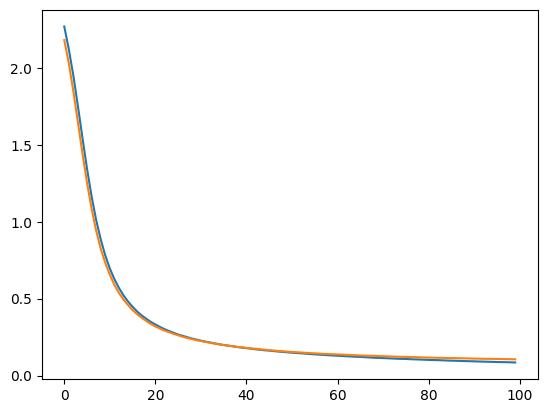

In [55]:
# 学習曲線
plt.plot(train_losses)
plt.plot(val_losses)

tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],


### パラメータのイテレーション

In [56]:
model

MLP(
  (l1): Linear(in_features=64, out_features=30, bias=True)
  (l2): Linear(in_features=30, out_features=10, bias=True)
)

In [58]:
for param in model.parameters():
    print(param.shape)

torch.Size([30, 64])
torch.Size([30])
torch.Size([10, 30])
torch.Size([10])


In [60]:
for name, param in model.named_parameters():
    # 名前はMLPの定義のself.l1とかからくる
    print(name, param.shape)

l1.weight torch.Size([30, 64])
l1.bias torch.Size([30])
l2.weight torch.Size([10, 30])
l2.bias torch.Size([10])


### コンポーネントのイテレーション

In [62]:
for module in model.children():
    print(module)

Linear(in_features=64, out_features=30, bias=True)
Linear(in_features=30, out_features=10, bias=True)


In [64]:
for mame, module in model.named_children():
    print(name, module)

l2.bias Linear(in_features=64, out_features=30, bias=True)
l2.bias Linear(in_features=30, out_features=10, bias=True)


In [65]:
for module in model.modules():
    print(module)

MLP(
  (l1): Linear(in_features=64, out_features=30, bias=True)
  (l2): Linear(in_features=30, out_features=10, bias=True)
)
Linear(in_features=64, out_features=30, bias=True)
Linear(in_features=30, out_features=10, bias=True)


In [66]:
for name, module in model.named_modules():
    print(name)


l1
l2
